In [222]:
# These packages are needed to use OpenCV in Studio as of February 2022
import platform
if platform.linux_distribution()[0] == "debian":
    ! apt-get update
    ! apt-get install ffmpeg libsm6 libxext6  -y

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  This is separate from the ipykernel package so we can avoid doing imports until


Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Hit:2 http://deb.debian.org/debian buster InRelease                            
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Fetched 91.5 kB in 0s (189 kB/s)    
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.1.9-0+deb10u1).
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [223]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

In [224]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-ObjectDetection-toys"

print("s3://{}/{}/".format(bucket, prefix))

s3://sagemaker-us-west-2-471222670403/DEMO-ObjectDetection-toys/


In [225]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::471222670403:role/service-role/AmazonSageMaker-ExecutionRole-20221003T214358


In [226]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)



In [227]:
%%time
# download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')
# CalTech's download is (at least temporarily) unavailable since August 2020.

# Can now use one made available by fast.ai .
#download("https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz")

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 172 µs


In [228]:
%%time
# Clean up prior version of the downloaded dataset if you are running this again
#!rm -rf CUB_200_2011

# Unpack and then remove the downloaded compressed tar file
#!gunzip -c ./CUB_200_2011.tgz | tar xopf -
#!rm CUB_200_2011.tgz

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [229]:
import pandas as pd
import cv2
import boto3
import json

runtime = boto3.client(service_name="runtime.sagemaker")

import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_SPLIT = False
SAMPLE_ONLY = False
FLIP = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [5, 10, 15, 25, 30]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(25):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR = "FOOTBALL_VS_CRICKET/"
IMAGES_DIR = BASE_DIR + "images/"

CLASSES_FILE = BASE_DIR + "classes.txt"
BBOX_FILE = BASE_DIR + "bounding_boxes.txt"
IMAGE_FILE = BASE_DIR + "images.txt"
LABEL_FILE = BASE_DIR + "image_class_labels.txt"
SIZE_FILE = BASE_DIR + "sizes.txt"
SPLIT_FILE = BASE_DIR + "train_test_split.txt"

TRAIN_LST_FILE = "toys_ssd_train.lst"
VAL_LST_FILE = "toys_ssd_val.lst"

if SAMPLE_ONLY:
    TRAIN_LST_FILE = "toys_ssd_sample_train.lst"
    VAL_LST_FILE = "toys_ssd_sample_val.lst"

TRAIN_RATIO = 1
CLASS_COLS = ["class_index", "class"]
IM2REC_SSD_COLS = [
    "header_cols",
    "label_width",
    "zero_based_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "image_file_name",
]

In [230]:
classes_df = pd.read_csv(CLASSES_FILE, sep=" ", names=CLASS_COLS)
criteria = classes_df["class_index"].isin(CLASSES)
classes_df = classes_df[criteria]
classes_df
print(classes_df.to_csv(sep="\t", index=False, header=False))

1	cricket_ball
2	soccer_ball



In [231]:
num_classes = classes_df.shape[0]
num_classes

images_df = pd.read_csv(
        IMAGE_FILE, sep=",", names=["image_pretty_name", "image_file_name"], header=None
    )

images_df = images_df.head(5)
images_df

,image_pretty_name,image_file_name
0,1 0027773a6d54b960.jpg,NaN
1,2 002af65597d93000.jpg,NaN
2,3 004130acea29204f.jpg,NaN
3,4 00490dffc1ce9a88.jpg,NaN
4,5 00ac400078dcfb49.jpg,NaN


In [232]:
%%time
SIZE_COLS = ["idx", "width", "height"]


def gen_image_size_file():
    print("Generating a file containing image sizes...")
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    
    rows_list = []
    idx = 0
    for i in images_df["image_file_name"]:
        # TODO: add progress bar
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        if img is not None:
            dimensions = img.shape
            height = img.shape[0]
            width = img.shape[1]
            image_dict = {"idx": idx, "width": width, "height": height}
            rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print("Image sizes:\n" + str(sizes_df.head()))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=" ", index=False, header=None)


gen_image_size_file()

Generating a file containing image sizes...
Image sizes:
   idx  width  height
0    1   1024     691
1    2   1024     769
2    3   1017     768
3    4    711    1024
4    5   1024     681
CPU times: user 12.1 s, sys: 254 ms, total: 12.3 s
Wall time: 17 s


In [233]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print(
            "\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}".format(
                lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)
            )
        )
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df


def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(
        SIZE_FILE, sep=" ", names=["image_pretty_name", "width", "height"], header=None
    )
    bboxes_df = pd.read_csv(
        BBOX_FILE,
        sep=" ",
        names=["image_pretty_name", "x_center", "y_center", "bbox_width", "bbox_height"],
        header=None,
    )
    split_df = pd.read_csv(
        SPLIT_FILE, sep=" ", names=["image_pretty_name", "is_training_image"], header=None
    )
    print(IMAGE_FILE)
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    print("num images total: " + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(LABEL_FILE, sep = " ",
                                        names=["image_pretty_name", "class_id"], header=None)
    #image_class_labels_df["image_pretty_name"] = image_class_labels_df["class_index"]
    
    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on="image_pretty_name")
    full_df = pd.merge(full_df, sizes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, bboxes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, split_df, on="image_pretty_name")
    print("full_df: " + str(full_df.shape[0]))
    
    full_df.sort_values(by=["index"], inplace=True)
    
    # Define the bounding boxes in the format (albumentations) required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df["header_cols"] = 2  # one col for the number of header cols, one for the label width
    full_df["label_width"] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    #full_df["xmin"] = full_df["x_abs"] / full_df["width"]
    #full_df["xmax"] = (full_df["x_abs"] + full_df["bbox_width"]) / full_df["width"]
    #full_df["ymin"] = full_df["y_abs"] / full_df["height"]
    #full_df["ymax"] = (full_df["y_abs"] + full_df["bbox_height"]) / full_df["height"]
    box_width = full_df["bbox_width"] * full_df["width"]
    box_height = full_df["bbox_height"] * full_df["height"]
    
    full_df["xmin"] = (full_df["x_center"] * full_df["width"] - box_width/2)/full_df["width"]
    full_df["xmax"] = (full_df["x_center"] * full_df["width"] + box_width/2)/full_df["width"]
    full_df["ymin"] = (full_df["y_center"] * full_df["height"] - box_height/2)/full_df["height"]
    full_df["ymax"] = (full_df["y_center"] * full_df["height"] + box_height/2)/full_df["height"]
    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df["class_id"].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df["class_id"].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df["zero_based_id"] = full_df["class_id"].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if RANDOM_SPLIT:
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, "class_id", TRAIN_RATIO)    
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)
    else:
        
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)

    print("num train: " + str(train_df.shape[0]))
    print("num val: " + str(val_df.shape[0]))
    
    return train_df, val_df

In [234]:
train_df, val_df = gen_list_files()



FOOTBALL_VS_CRICKET/images.txt
num images total: 869
full_df: 1009
num train: 796
num val: 213


In [235]:
!tail -3 $TRAIN_LST_FILE

1001	2	5	1.0000	0.4854	0.6960	0.5273	0.7606	fe77cda7d03e28a7.jpg
1002	2	5	1.0000	0.6416	0.8082	0.7627	0.9824	fee50fd0208ffdb4.jpg
1007	2	5	1.0000	0.5961	0.8301	0.7919	0.9814	ffd627061d34ee2e.jpg


In [236]:
!apt-get install python-opencv -y
!python amazon-sagemaker-examples/introduction_to_amazon_algorithms/object_detection_birds/tools/im2rec.py --resize $RESIZE_SIZE --pack-label toys_ssd $BASE_DIR/images/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opencv is already the newest version (3.2.0+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.
Creating .rec file from /root/toys_ssd_train.lst in /root
multiprocessing not available, fall back to single threaded encoding
time: 0.019554615020751953  count: 0
Creating .rec file from /root/toys_ssd_val.lst in /root
multiprocessing not available, fall back to single threaded encoding
time: 0.017705202102661133  count: 0


In [237]:
# Upload the RecordIO files to train and validation channels
train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path="toys_ssd_train.rec", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="toys_ssd_val.rec", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

In [238]:
from sagemaker import image_uris

training_image = image_uris.retrieve(
    region=sess.boto_region_name, framework="object-detection", version="latest"
)
print(training_image)



Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:1


In [239]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

In [240]:
od_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

In [241]:
def set_hyperparameters(num_epochs, lr_steps):
    num_classes = classes_df.shape[0]
    num_training_samples = train_df.shape[0]
    print("num classes: {}, num training images: {}".format(num_classes, num_training_samples))

    od_model.set_hyperparameters(
        base_network="resnet-50",
        use_pretrained_model=1,
        num_classes=num_classes,
        mini_batch_size=16,
        epochs=num_epochs,
        learning_rate=0.001,
        lr_scheduler_step=lr_steps,
        lr_scheduler_factor=0.1,
        optimizer="sgd",
        momentum=0.9,
        weight_decay=0.0005,
        overlap_threshold=0.9,
        nms_threshold=0.45,
        image_shape=512,
        label_width=350,
        num_training_samples=num_training_samples
    )
    
set_hyperparameters(100, "33,67")
 

num classes: 2, num training images: 796


In [242]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

In [243]:
%%time
od_model.fit(inputs=data_channels, logs=True)



2022-10-07 13:30:05 Starting - Starting the training job...
2022-10-07 13:30:31 Starting - Preparing the instances for trainingProfilerReport-1665149405: InProgress
.........
2022-10-07 13:31:51 Downloading - Downloading input data...
2022-10-07 13:32:28 Training - Downloading the training image...............
2022-10-07 13:34:58 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[10/07/2022 13:35:04 INFO 140324391376704] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold':

mAP tracking for job: object-detection-2022-10-06-13-48-20-953
Maximum mAP: 0.030350 


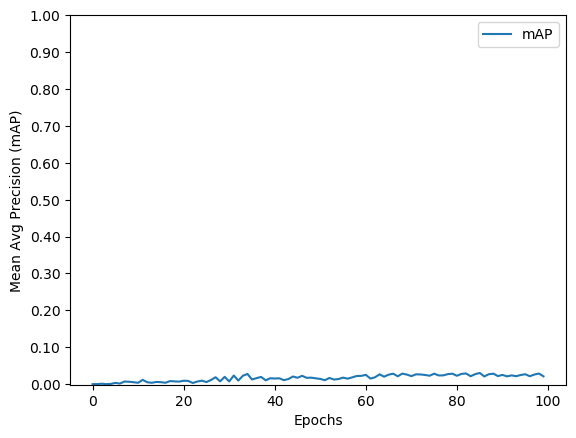

In [201]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()
    
plot_object_detection_log(od_model, "mAP tracking for job: " + od_model._current_job_name)


In [202]:
%%time
object_detector = od_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----------!CPU times: user 178 ms, sys: 17.8 ms, total: 196 ms
Wall time: 5min 31s


In [212]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    img = mpimg.imread(img_file)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    num_detections = 0
    for det in dets:
        (klass, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
        num_detections += 1
        cls_id = int(klass)
        if cls_id not in colors:
            colors[cls_id] = (random.random(), random.random(), random.random())
        xmin = int(x0 * width)
        ymin = int(y0 * height)
        xmax = int(x1 * width)
        ymax = int(y1 * height)
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=colors[cls_id],
            linewidth=3.5,
        )
        plt.gca().add_patch(rect)
        class_name = str(cls_id)
        if classes and len(classes) > cls_id:
            class_name = classes[cls_id]
        print("Detected Class {} with a score of {}".format(class_name, score))
        plt.gca().text(
            xmin,
            ymin - 2,
            "{:s} {:.3f}".format(str(class_name), score),
            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
            fontsize=12,
            color="white",
        )

    print("Number of detections: " + str(num_detections))
    plt.show()
    print("\n------------------------------------------")



In [213]:
OBJECT_CATEGORIES = classes_df["class_index"].values.tolist()


def show_ball_prediction(filename, ep, thresh=0.40):
    b = ""
    with open(filename, "rb") as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep, ContentType="image/jpeg", Body=b)
    results = endpoint_response["Body"].read()
    detections = json.loads(results)
    visualize_detection(filename, detections["prediction"], OBJECT_CATEGORIES, thresh)

Class detected:2 with a score of 0.6549723148345947
Number of detections: 1


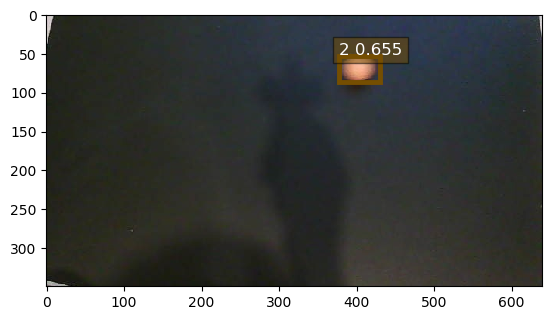




Class detected:2 with a score of 0.7305653095245361
Number of detections: 1


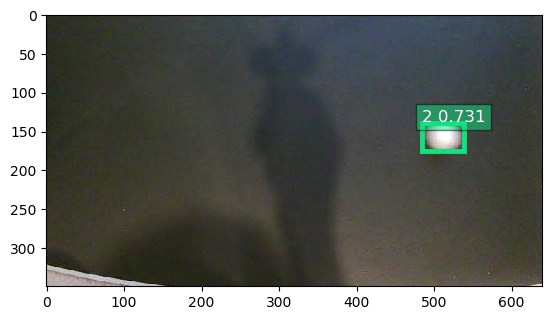




Class detected:2 with a score of 0.8502113819122314
Number of detections: 1


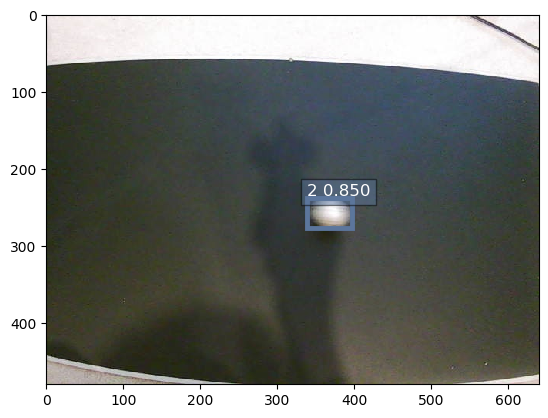

In [219]:
def test_model():
    show_ball_prediction("test/positive/img468.jpg", object_detector.endpoint_name)
    show_ball_prediction("test/positive/img47.jpg", object_detector.endpoint_name)
    show_ball_prediction("test/positive/img42.jpg", object_detector.endpoint_name)

test_model()

**Flipping images**

In [216]:
from PIL import Image


def flip_images():
    print("Flipping images...")

    SIZE_COLS = ["idx", "width", "height"]
    IMAGE_COLS = ["image_pretty_name", "image_file_name"]
    LABEL_COLS = ["image_pretty_name", "class_id"]
    BBOX_COLS = ["image_pretty_name", "x_abs", "y_abs", "bbox_width", "bbox_height"]
    SPLIT_COLS = ["image_pretty_name", "is_training_image"]

    images_df = pd.read_csv(BASE_DIR + "images.txt", sep=" ", names=IMAGE_COLS, header=None)
    image_class_labels_df = pd.read_csv(
        BASE_DIR + "image_class_labels.txt", sep=" ", names=LABEL_COLS, header=None
    )
    bboxes_df = pd.read_csv(BASE_DIR + "bounding_boxes.txt", sep=" ", names=BBOX_COLS, header=None)
    split_df = pd.read_csv(
        BASE_DIR + "train_test_split.txt", sep=" ", names=SPLIT_COLS, header=None
    )
    
    sizes_df = pd.read_csv(
        SIZE_FILE, sep=" ", names=["image_pretty_name", "width", "height"], header=None
    )
    
    NUM_ORIGINAL_IMAGES = images_df.shape[0]

    rows_list = []
    bbox_rows_list = []
    size_rows_list = []
    label_rows_list = []
    split_rows_list = []

    idx = 0

    full_df = images_df.copy()
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on="image_pretty_name")
    full_df = pd.merge(full_df, bboxes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, split_df, on="image_pretty_name")
    full_df.sort_values(by=["index"], inplace=True)

    box_width = full_df["bbox_width"] * full_df["width"]
    box_height = full_df["bbox_height"] * full_df["height"]
    
    full_df["xmin"] = (full_df["x_center"] * full_df["width"] - box_width/2)/full_df["width"]
    full_df["xmax"] = (full_df["x_center"] * full_df["width"] + box_width/2)/full_df["width"]
    full_df["ymin"] = (full_df["y_center"] * full_df["height"] - box_height/2)/full_df["height"]
    full_df["ymax"] = (full_df["y_center"] * full_df["height"] + box_height/2)/full_df["height"]
    
    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df["class_id"].isin(CLASSES)
        full_df = full_df[criteria]

    for rel_image_fn in full_df["image_file_name"]:
        idx += 1
        full_img_content = full_df[(full_df.image_file_name == rel_image_fn)]

        class_id = full_img_content.iloc[0].class_id

        img = Image.open(IMAGES_DIR + rel_image_fn)

        width, height = img.size

        new_idx = idx + NUM_ORIGINAL_IMAGES

        flip_core_file_name = rel_image_fn[:-4] + "_flip.jpg"
        flip_full_file_name = IMAGES_DIR + flip_core_file_name

        img_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_flip.save(flip_full_file_name)

        # append a new image
        dict = {"image_pretty_name": new_idx, "image_file_name": flip_core_file_name}
        rows_list.append(dict)

        # append a new split, use same flag for flipped image from original image
        is_training_image = full_img_content.iloc[0].is_training_image
        split_dict = {"image_pretty_name": new_idx, "is_training_image": is_training_image}
        split_rows_list.append(split_dict)

        # append a new image class label
        label_dict = {"image_pretty_name": new_idx, "class_id": class_id}
        label_rows_list.append(label_dict)

        # add a size row for the original and the flipped image, same height and width
        size_dict = {"idx": idx, "width": width, "height": height}
        size_rows_list.append(size_dict)

        size_dict = {"idx": new_idx, "width": width, "height": height}
        size_rows_list.append(size_dict)

        # append bounding box for flipped image
        x_abs = full_img_content.iloc[0].x_abs
        y_abs = full_img_content.iloc[0].y_abs
        bbox_width = full_img_content.iloc[0].bbox_width
        bbox_height = full_img_content.iloc[0].bbox_height
        flipped_x_abs = width - bbox_width - x_abs

        bbox_dict = {
            "image_pretty_name": new_idx,
            "x_abs": flipped_x_abs,
            "y_abs": y_abs,
            "bbox_width": bbox_width,
            "bbox_height": bbox_height,
        }
        bbox_rows_list.append(bbox_dict)

    print("Done looping through original images")

    images_df = images_df.append(rows_list)
    images_df[IMAGE_COLS].to_csv('images_with_flip.txt', sep=" ", index=False, header=None)
    bboxes_df = bboxes_df.append(bbox_rows_list)
    bboxes_df[BBOX_COLS].to_csv('bounding_boxes_with_flip.txt', sep=" ", index=False, header=None)
    split_df = split_df.append(split_rows_list)
    split_df[SPLIT_COLS].to_csv('train_test_split_with_flip.txt', sep=" ", index=False, header=None)
    sizes_df = pd.DataFrame(size_rows_list)
    sizes_df[SIZE_COLS].to_csv('sizes_with_flip.txt', sep=" ", index=False, header=None)
    image_class_labels_df = image_class_labels_df.append(label_rows_list)
    image_class_labels_df[LABEL_COLS].to_csv('image_class_labels_with_flip.txt', sep=" ", index=False, header=None)

    print("Done saving metadata in text files")

In [217]:
%%time

BBOX_FILE = BASE_DIR + "bounding_boxes_with_flip.txt"
IMAGE_FILE = BASE_DIR + "images_with_flip.txt"
LABEL_FILE = BASE_DIR + "image_class_labels_with_flip.txt"
SIZE_FILE = BASE_DIR + "sizes_with_flip.txt"
SPLIT_FILE = BASE_DIR + "train_test_split_with_flip.txt"

# add a set of flipped images
flip_images()

# create new sizes file
gen_image_size_file()

# re-create and re-deploy the RecordIO files with the updated set of images
train_df, val_df = gen_list_files()
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/
sess.upload_data(path="birds_ssd_sample_train.rec", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="birds_ssd_sample_val.rec", bucket=bucket, key_prefix=validation_channel)

# account for the new number of training images
set_hyperparameters(100, "33,67")

# re-train
od_model.fit(inputs=data_channels, logs=True)

# check out the new accuracy
plot_object_detection_log(od_model, "mAP tracking for job: " + od_model._current_job_name)

Flipping images...


KeyError: 'width'

In [ ]:
%%time
object_detector = od_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)